In [1]:
import pandas as pd
import numpy as np
import urllib.request
import os
import matplotlib.pyplot as plt

pd.__version__

'2.2.3'

In [2]:
# data pull / cache

data_url = "https://raw.githubusercontent.com/alexeygrigorev/datasets/master/laptops.csv"

filename = "laptops_data.csv"

if not os.path.exists(filename):
    urllib.request.urlretrieve(data_url, filename)

df_raw = pd.read_csv(filename)

In [3]:
df_raw.head(2)

,Laptop,Status,Brand,Model,CPU,RAM,Storage,Storage type,GPU,Screen,Touch,Final Price
0,ASUS ExpertBook B1 B1502CBA-EJ0436X Intel Core...,New,Asus,ExpertBook,Intel Core i5,8,512,SSD,NaN,15.6,No,1009.0
1,Alurin Go Start Intel Celeron N4020/8GB/256GB ...,New,Alurin,Go,Intel Celeron,8,256,SSD,NaN,15.6,No,299.0


In [4]:
# data processing

def normalize_data(df):
    df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")
    return df

df = normalize_data(df_raw)
df.head(2)

,laptop,status,brand,model,cpu,ram,storage,storage_type,gpu,screen,touch,final_price
0,ASUS ExpertBook B1 B1502CBA-EJ0436X Intel Core...,New,Asus,ExpertBook,Intel Core i5,8,512,SSD,NaN,15.6,No,1009.0
1,Alurin Go Start Intel Celeron N4020/8GB/256GB ...,New,Alurin,Go,Intel Celeron,8,256,SSD,NaN,15.6,No,299.0


In [5]:
# extact features

data = df[["ram", "storage", "screen", "final_price"]]
data.head(2)

,ram,storage,screen,final_price
0,8,512,15.6,1009.0
1,8,256,15.6,299.0


## EDA

In [6]:
df["final_price"].describe()

count    2160.000000
mean     1312.638509
std       911.475417
min       201.050000
25%       661.082500
50%      1031.945000
75%      1708.970000
max      7150.470000
Name: final_price, dtype: float64

(array([367., 547., 363., 243., 235., 129.,  80.,  61.,  39.,  27.,  33.,
         10.,  10.,   9.,   3.,   2.,   1.,   0.,   0.,   1.]),
 array([ 201.05 ,  548.521,  895.992, 1243.463, 1590.934, 1938.405,
        2285.876, 2633.347, 2980.818, 3328.289, 3675.76 , 4023.231,
        4370.702, 4718.173, 5065.644, 5413.115, 5760.586, 6108.057,
        6455.528, 6802.999, 7150.47 ]),
 <BarContainer object of 20 artists>)

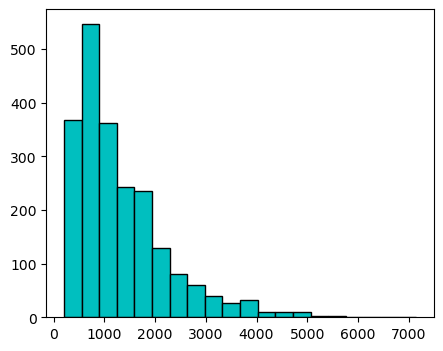

In [7]:
# check distro skew / kurtosis / tails

plt.figure(figsize=(5, 4))
plt.hist(df["final_price"], bins=20, color='c', edgecolor='black') # long tail distro

In [8]:
# check nans

data.isna().sum()

ram            0
storage        0
screen         4
final_price    0
dtype: int64

In [9]:
# eda for ram

df["ram"].describe()

count    2160.000000
mean       15.413889
std         9.867815
min         4.000000
25%         8.000000
50%        16.000000
75%        16.000000
max       128.000000
Name: ram, dtype: float64

In [10]:
# eda for storage

df["storage"].describe()

count    2160.000000
mean      596.294444
std       361.220506
min         0.000000
25%       256.000000
50%       512.000000
75%      1000.000000
max      4000.000000
Name: storage, dtype: float64

In [11]:
# eda for screen

df["screen"].describe()

count    2156.000000
mean       15.168112
std         1.203329
min        10.100000
25%        14.000000
50%        15.600000
75%        15.600000
max        18.000000
Name: screen, dtype: float64

Text(0.5, 1.0, 'Price')

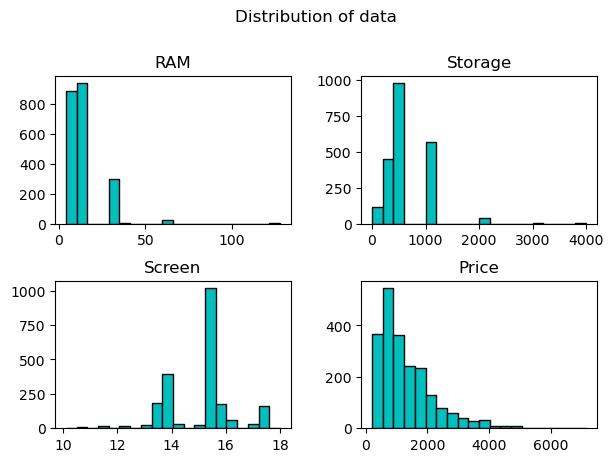

In [12]:
fig, (ax, ay) = plt.subplots(2, 2)
fig.suptitle("Distribution of data")

plt.tight_layout(pad=2)

ax[0].hist(df["ram"], bins=20, color='c', edgecolor='black')
ax[0].set_title("RAM")

ax[1].hist(df["storage"], bins=20, color='c', edgecolor='black')
ax[1].set_title("Storage")

ay[0].hist(df["screen"], bins=20, color='c', edgecolor='black')
ay[0].set_title("Screen")

ay[1].hist(df["final_price"], bins=20, color='c', edgecolor='black')
ay[1].set_title("Price")

## Prepare dataset

In [13]:
def shuffle(df, seed=None):
    if seed is not None and isinstance(seed, int):
        np.random.seed(seed)
    else:
        np.random.seed(42)
    idx = np.arange(df.shape[0])
    np.random.shuffle(idx)
    return df.iloc[idx]

# quick test

test_df = data.copy()
s_df = shuffle(test_df)

assert s_df.shape == test_df.shape
assert s_df["ram"].tolist() != test_df["ram"].tolist()

In [14]:
# shuffle data

# data = shuffle(data)

In [15]:
def data_split(data, train_size=0.6, val_size=0.2, test_size=0.2, seed=None):
    if any([train_size >= 1, val_size >= 1, test_size >= 1]):
        raise ValueError("train, val, test sizes must be less than 1")
    
    if any([train_size <= 0, val_size <= 0, test_size <= 0]):
        raise ValueError("train, val, test sizes must be greater than 0")
    
    if train_size + val_size + test_size != 1:
        raise ValueError("train, val, test sizes must sum to 1")
    
    if seed is None or not isinstance(seed, int):
        seed = 42

    n = len(data)
    n_val, n_test = 0, 0
    
    if val_size > 0:
        n_val = int(n * val_size)

    if test_size > 0:
        n_test = int(n * test_size)

    n_train = n - n_val - n_test

    idx = np.arange(n)
    np.random.seed(seed)
    np.random.shuffle(idx)

    df_train = data.iloc[idx[:n_train]].copy()
    df_val = data.iloc[idx[n_train:n_train+n_val]].copy()
    df_test = data.iloc[idx[n_train+n_val:]].copy()

    return df_train, df_val, df_test

In [16]:
df_train, df_val, df_test = data_split(data, train_size=0.6, val_size=0.2, test_size=0.2)
assert df_train.shape[0] + df_val.shape[0] + df_test.shape[0] == data.shape[0]

print(df_train.shape, df_val.shape, df_test.shape)


(1296, 4) (432, 4) (432, 4)


## Model definition

In [17]:
def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)

    return w[0], w[1:] 


def prepare_X_y(df):
    df = df.copy()
    y = df["final_price"].values
    # y = np.log1p(y)
    del df["final_price"]
    X = df.values
    return X, y


def rmse(y, y_pred):
    se = (y - y_pred) ** 2
    mse = se.mean()
    return np.sqrt(mse)

## Test run #1 - fill missings with 0

In [18]:
X_train_1, y_train_1 = prepare_X_y(df_train.fillna(0))
X_val_1, y_val_1 = prepare_X_y(df_val.fillna(0))
X_test_1, y_test_1 = prepare_X_y(df_test.fillna(0))

w_0, w = train_linear_regression(X_train_1, y_train_1)
score_val_1 = rmse(y_val_1, X_val_1.dot(w) + w_0)

print("Validation err #1:", score_val_1.round(2))

Validation err #1: 597.36


## Test run #2 - fill missings with mean

In [19]:
na_mean = df_train["ram"].mean()

X_train_2, y_train_2 = prepare_X_y(df_train.fillna(na_mean))
X_val_2, y_val_2 = prepare_X_y(df_val.fillna(na_mean))
X_test_2, y_test_2 = prepare_X_y(df_test.fillna(na_mean))

w_0, w = train_linear_regression(X_train_2, y_train_2)
score_val_2 = rmse(y_val_2, X_val_2.dot(w) + w_0)

print("Validation err #2:", score_val_2.round(2))

Validation err #2: 600.36


## Regularization

In [20]:
def train_linear_regression_with_reg(X, y, r):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX += r * np.eye(XTX.shape[0])
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)

    return w[0], w[1:] 


def prepare_X_y(df):
    df = df.copy()
    y = df["final_price"].values
    # y = np.log1p(y)
    del df["final_price"]
    X = df.values
    return X, y


def rmse(y, y_pred):
    se = (y - y_pred) ** 2
    mse = se.mean()
    return np.sqrt(mse)

In [21]:
scores = dict()
hyperparameters = [0, 0.01, 0.1, 1, 5, 10, 100]

for r in hyperparameters:
    X_train, y_train = prepare_X_y(df_train.fillna(0))
    X_val, y_val = prepare_X_y(df_val.fillna(0))

    w_0, w = train_linear_regression_with_reg(X_train, y_train, r)
    score = rmse(y_val, X_val.dot(w) + w_0)
    scores[r] = score.round(2)

for r, score in scores.items():
    print(f"Regularization: {r}, Validation error: {score}")

best_r = min(scores, key=scores.get)
print(f"Best regularization: {best_r}")

Regularization: 0, Validation error: 597.36
Regularization: 0.01, Validation error: 597.36
Regularization: 0.1, Validation error: 597.35
Regularization: 1, Validation error: 597.21
Regularization: 5, Validation error: 597.01
Regularization: 10, Validation error: 597.06
Regularization: 100, Validation error: 597.9
Best regularization: 5


## Influence of random seed

In [22]:
seeds = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
scores = dict()

for seed in seeds:
    df_train, df_val, df_test = data_split(
        data, train_size=0.6, val_size=0.2, test_size=0.2, seed=seed
        )
    
    X_train, y_train = prepare_X_y(df_train.fillna(0))
    X_val, y_val = prepare_X_y(df_val.fillna(0))
    X_test, y_test = prepare_X_y(df_test.fillna(0))

    w_0, w = train_linear_regression(X_train, y_train)
    score_val = rmse(y_val, X_val.dot(w) + w_0)
    
    scores[seed] = score_val.round(3)

for seed, score in scores.items():
    print(f"Validation error for seed={seed}: {score}")

stdev = np.std(list(scores.values()))
print(f"stdev of validation errors: {stdev:.3f}")

Validation error for seed=0: 565.452
Validation error for seed=1: 636.799
Validation error for seed=2: 588.956
Validation error for seed=3: 597.815
Validation error for seed=4: 571.963
Validation error for seed=5: 573.238
Validation error for seed=6: 647.344
Validation error for seed=7: 550.44
Validation error for seed=8: 587.334
Validation error for seed=9: 576.102
stdev of validation errors: 29.177


## Final iteration

In [23]:
seed = 9

df_train, df_val, df_test = data_split(
        data, train_size=0.6, val_size=0.2, test_size=0.2, seed=seed
    )

df_train = pd.concat([df_train, df_val])

X_train, y_train = prepare_X_y(df_train.fillna(0))
X_test, y_test = prepare_X_y(df_test.fillna(0))

w_0, w = train_linear_regression_with_reg(X_train, y_train, r=0.001)

score = rmse(y_test, X_test.dot(w) + w_0)

print(f"Test error: {score:.2f}")

Test error: 608.61
